# Multiclass Classification

In this notebook we will have a look at a dataset which is often called the "Hello world!" of Machine Learning. We will take the iris dataset, make a short EDA and train a logistic regression model to predict the species of new instances. 

At this point of the course the structure of the notebook should be familiar to you. At the end you should:
* know one of the most popular data sets in machine learning ;) 
* know how to apply logistic regression to a multiclass problem

## Setup and Data

We will begin with importing the required libraries and data. This time we will import the dataset directly from sklearn. Sklearn provide some of the most commonly used [toy data sets](https://scikit-learn.org/stable/datasets/toy_dataset.html) for learning and practicing machine learning. 

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['font.size'] = 14
plt.rcParams['figure.figsize'] = (11, 7)

In [16]:
# Import data from sklearn.datasets
data = load_iris()

# Define features and target
X = data.data
y = data.target
target_names = data.target_names

# Convert arrays to dataframe
df_X = pd.DataFrame(X, columns=data.feature_names)
df_y = pd.DataFrame(y, columns=['species'])
df_y.species.replace({0: target_names[0], 1: target_names[1], 2: target_names[2]}, inplace=True)
iris = df_X.join(df_y)
target_names = data.target_names

C:\Users\email\AppData\Local\Temp\ipykernel_34124\3423592436.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_y.species.replace({0: target_names[0], 1: target_names[1], 2: target_names[2]}, inplace=True)


In [3]:
# Check result
iris.head(2)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa


## Getting a feel for the data

Before we dive into the modelling part we will examine the data. 

In [8]:
# Checking the columns and data types 
iris.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
 4   species            150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


In [9]:
# Descriptive statistics 
iris.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [10]:
# Checking for number of unique values
iris.nunique()

sepal length (cm)    35
sepal width (cm)     23
petal length (cm)    43
petal width (cm)     22
species               3
dtype: int64

In [11]:
# Checking for missing values
iris.isnull().sum()

sepal length (cm)    0
sepal width (cm)     0
petal length (cm)    0
petal width (cm)     0
species              0
dtype: int64

The information above look promising: 
* We have four features which seem to be all numerical ones. Our target variable *species* is categorical. 
* None of our columns has missing data. 
* Based on the table with the descriptive statistics we can assume that there are no strong outliers. 

It's always a good idea to visualize the data to get more insight and to confirm our first assumptions.

## Visualisation 

We will start by plotting the target variable. We can see that our dataset is very balanced with 50 specimens of each species. That's good, so we won't have to deal with an imbalanced data set when it comes to the modelling part.

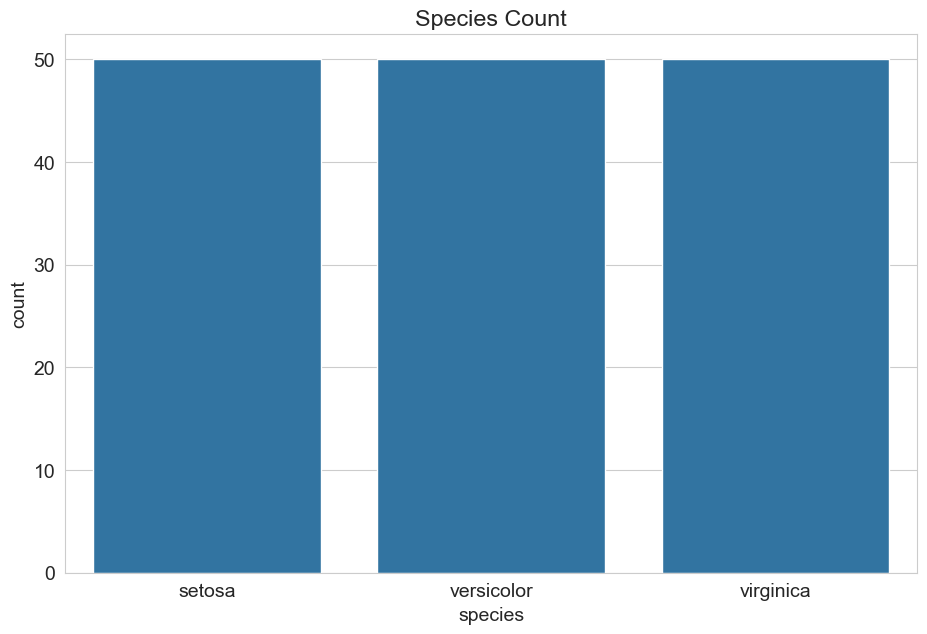

In [17]:
# Plotting the target variable
plt.title('Species Count')
sns.countplot(x=iris.species);

A pair plot is good to see all the column relationships at once. It's perfect to get an overview of the data but not really useful when it comes to presenting our work to someone else.

We can see from the pair plot that the three species can be pretty well separated. There seem to be only minor overlaps between the species versicolor and virginica. This is good and will hopefully result in a good performance of our model. 

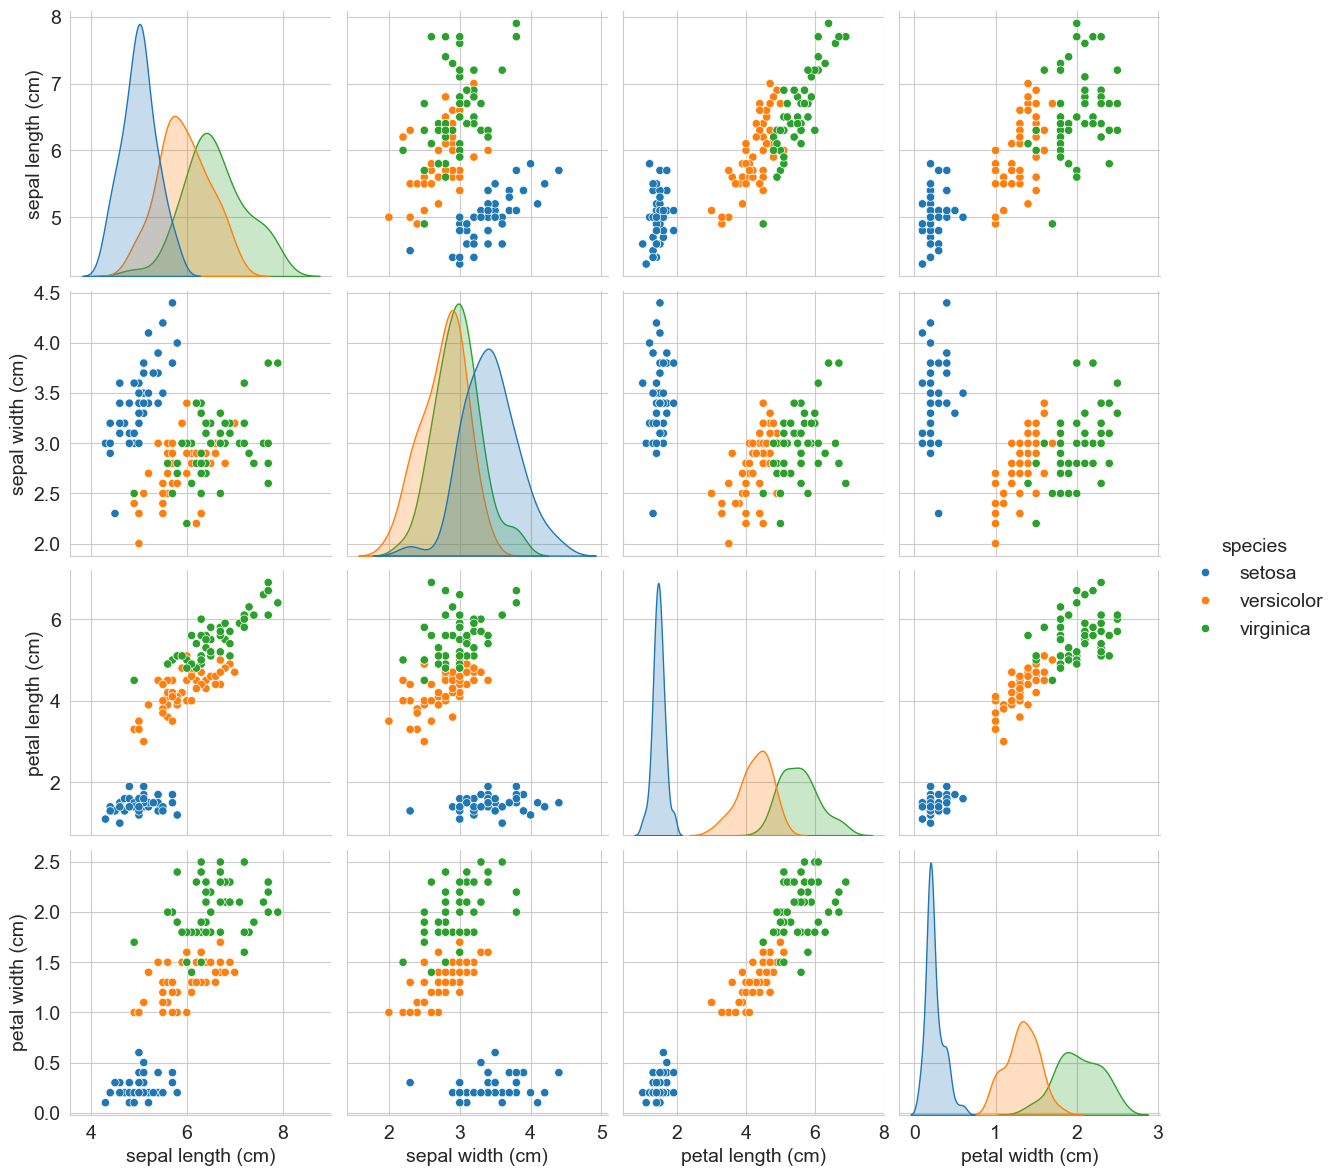

In [18]:
sns.pairplot(iris, hue="species", height=3);

To confirm our first impression from the pairplot we can pick some of the feature combinations and visualize them again with bigger plots. 

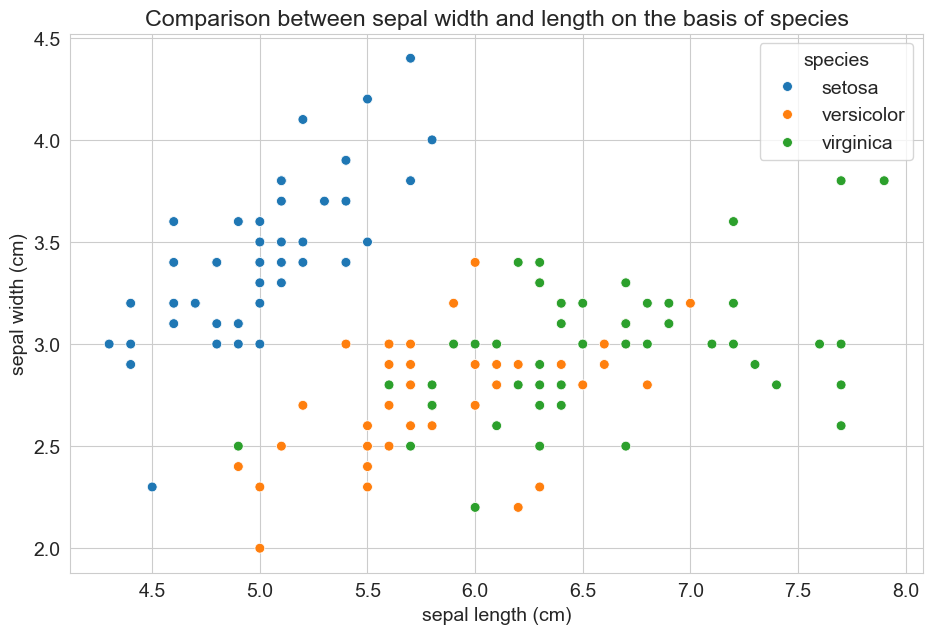

In [19]:
plt.title('Comparison between sepal width and length on the basis of species')
sns.scatterplot(x=iris['sepal length (cm)'], y=iris['sepal width (cm)'], hue = iris['species'], s= 50);

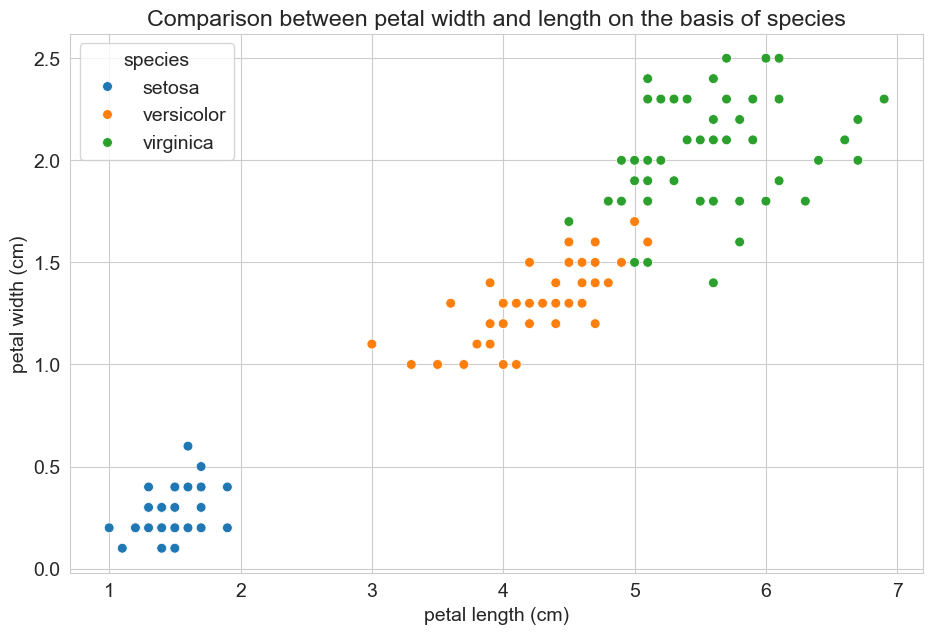

In [20]:
plt.title('Comparison between petal width and length on the basis of species')
sns.scatterplot(x=iris['petal length (cm)'], y=iris['petal width (cm)'], hue = iris['species'], s= 50);

It is clearly visible that the species iris setosa is separable from the other two species, while there is some overlapping regarding iris versicolor and iris virginica.

It's always worth to have a look at the correlations of our numerical features. 
From the heatmap we can see that petal length and petal width are strongly correlated. Sepal length shows also a strong correlation to petal length and petal width. 

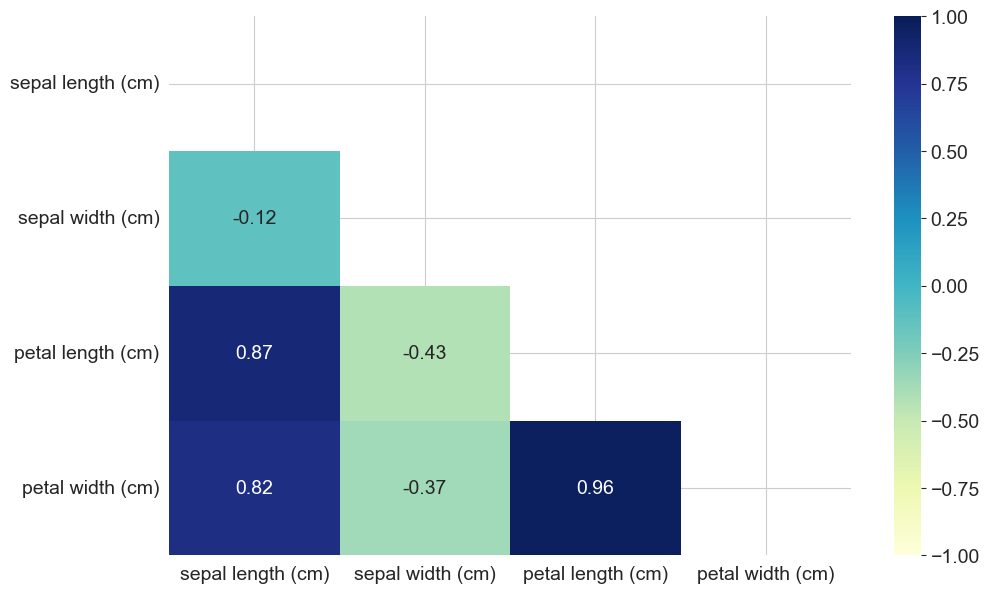

In [21]:
# Correlation heatmap 
correlations = iris.corr(numeric_only=True)
mask = np.triu(correlations)
sns.heatmap(correlations , vmax=1, vmin=-1, annot=True, mask=mask, cmap="YlGnBu");

## Predictive Modelling

Our aim is to train a model which predicts the iris species based on its petal and sepal measures. In our case we are not dealing with a binary classification problem but with a multiclass classification problem. Our model should be able to predict one of the three iris species. 

Writing the code for training a multiclass logistic regression model works exactly as when dealing with a binary problem. If you are interested in how logistic regression handles multiclass problems have a look at the sklearn [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).

After we defined our features and the target variable we will split the dataset into 70% trainings data and 30% testing data. We will train (fit) our logistic regression model on the training data and evaluate the performance on the remaining 30%. 

Since our dataset is completely balanced we decide that accuracy is a good metric to evaluate the performance of our model. 

In [22]:
# Defining X and y
features = iris.columns.tolist()
features.remove('species')
X = iris[features]
y = iris.species

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=150, shuffle=True)

# Check the shape of the data sets
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)

X_train: (105, 4)
y_train: (105,)
X_test: (45, 4)
y_test: (45,)


Accuracy on train set: 0.98
Accuracy on test set: 0.96
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        17
  versicolor       1.00      0.88      0.93        16
   virginica       0.86      1.00      0.92        12

    accuracy                           0.96        45
   macro avg       0.95      0.96      0.95        45
weighted avg       0.96      0.96      0.96        45

--------------------------------------------------------------------------------


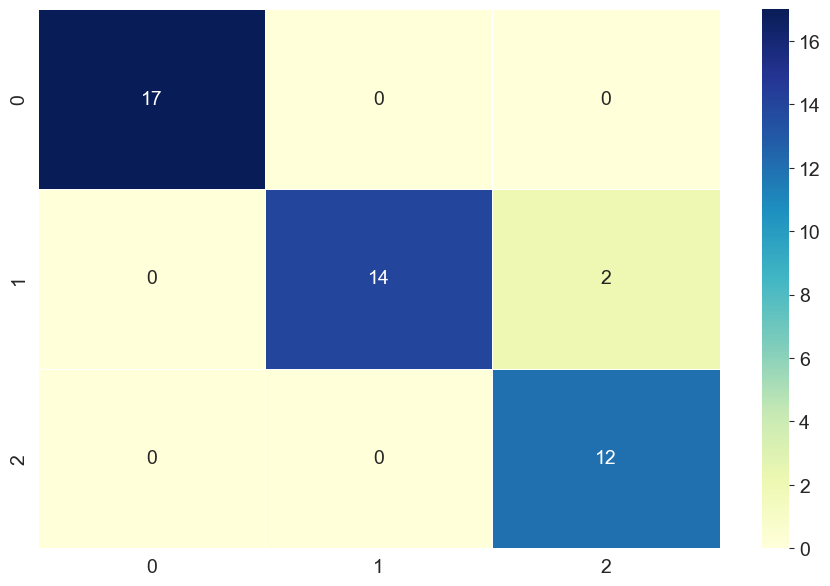

In [23]:
# Logistic Regression
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

y_pred_train = log_reg.predict(X_train)
y_pred = log_reg.predict(X_test)

# Print accuracy of our model
print("Accuracy on train set:", round(accuracy_score(y_train, y_pred_train), 2))
print("Accuracy on test set:", round(accuracy_score(y_test, y_pred), 2))
print("--------"*10)

# Print classification report of our model
print(classification_report(y_test, y_pred))
print("--------"*10)

# Evaluate the model with a confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, cmap='YlGnBu', annot=True, fmt='d', linewidths=.5);

Our model is working pretty well. We reached an accuracy of 0.98 on the train set and 0.96 on our test set. That's really good. 
If we have a look at the confusion matrix we can see that our model perfectly classified all instances of iris setosa really as iris setosa. 
There were only two instances which were classified incorrectly. Two instances of the species iris versicolor were falsely classified as iris virginica. If we recall our observations from the EDA regarding the separability of the three species this is not a big surprise. 